Sales forecasting plays an integral role in setting expectations and making plans for your business. It’s your best shot at predicting the future. Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. 

I will be performing an exhaustive analysis in order to gain insights and engineer features with an interactive exploratory analysis and finally will use XGB to predict. 

### Importing Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

import datetime
import math
import calendar

# Thanks for providing this in the forum
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

### Importing Data

In [ ]:
train = pd.read_csv('rossmann-store-sales/train.csv')
test = pd.read_csv('rossmann-store-sales/test.csv')
store = pd.read_csv('rossmann-store-sales/store.csv')

train.shape, test.shape, store.shape

((1017209, 9), (41088, 8), (1115, 10))

### Joining

In [ ]:
train.Store.nunique() == store.Store.nunique()

True

In [ ]:
df = train.merge(store, how='left', left_on=train.Store, right_on=store.Store)
df.drop(['key_0', 'Store_y'], axis=1, inplace=True)
df = df.rename(columns={'Store_x':'Store'})
df.shape

(1017209, 18)

### Understanding the Data

In [ ]:
round(df.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.43,321.91,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,4.00,2.00,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.82,3849.93,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.15,464.41,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.83,0.38,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.38,0.49,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.18,0.38,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,1014567.0,5430.09,7715.32,20.0,710.0,2330.0,6890.0,75860.0
CompetitionOpenSinceMonth,693861.0,7.22,3.21,1.0,4.0,8.0,10.0,12.0
CompetitionOpenSinceYear,693861.0,2008.69,5.99,1900.0,2006.0,2010.0,2013.0,2015.0


There are in total 1115 stores with sales feature having 3849.93 volatility and feature customers having 464.41 volatility with a mean of 57773.82 and 633.15 respectively.

In [ ]:
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [ ]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 11)

There are no duplicates and Testing dataset has 11 null values.

In [ ]:
print("Training data starts from: {}".format(train.Date.min()))
print("Training data end on: {}".format(train.Date.max()))
print()
print("Testing data starts from: {}".format(test.Date.min()))
print("Testing data end on: {}".format(test.Date.max()))

Training data starts from: 2013-01-01
Training data end on: 2015-07-31

Testing data starts from: 2015-08-01
Testing data end on: 2015-09-17


### Exploratory Data Analysis

In [ ]:
df.Date = pd.to_datetime(df.Date)
df['Day'] = df.Date.dt.day
df['Month'] = df.Date.dt.month
df['Year'] = df.Date.dt.year

I wish to explore seasonality and trend in the dataset and somehow engineer and pre-process features with the analysis I perform.

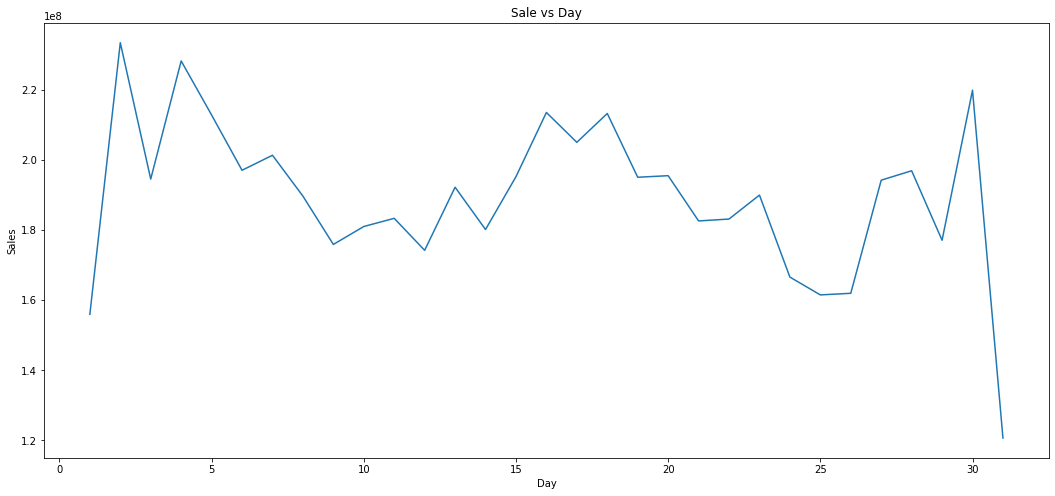

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby(df.Day).sum().Sales)
plt.title("Sale vs Day")
plt.xlabel('Day')
plt.ylabel('Sales')
plt.show()

Most Sales are done in the beginning of the month with end of the month being the lowest. 

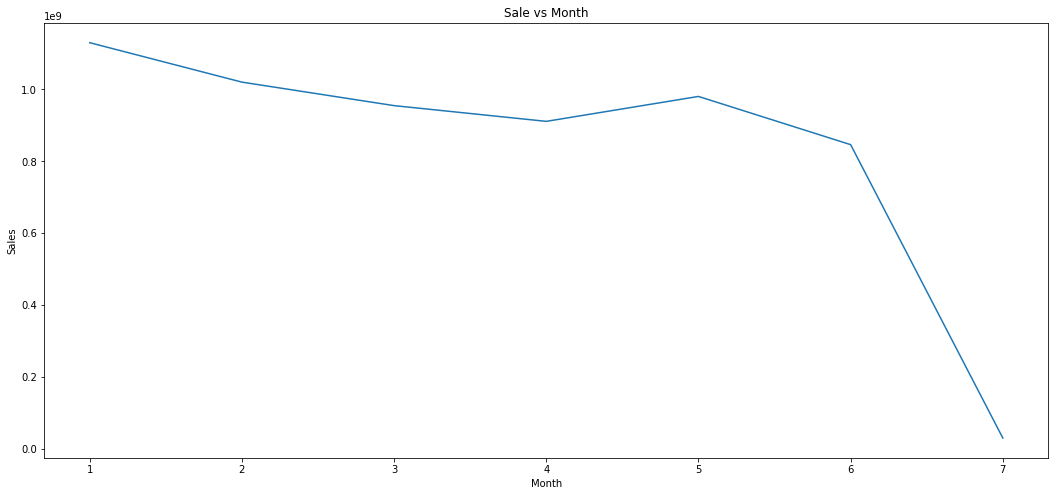

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby(df.DayOfWeek).sum().Sales)
plt.title("Sale vs Month")
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

Sales are more in the beginning of the week than the end. 

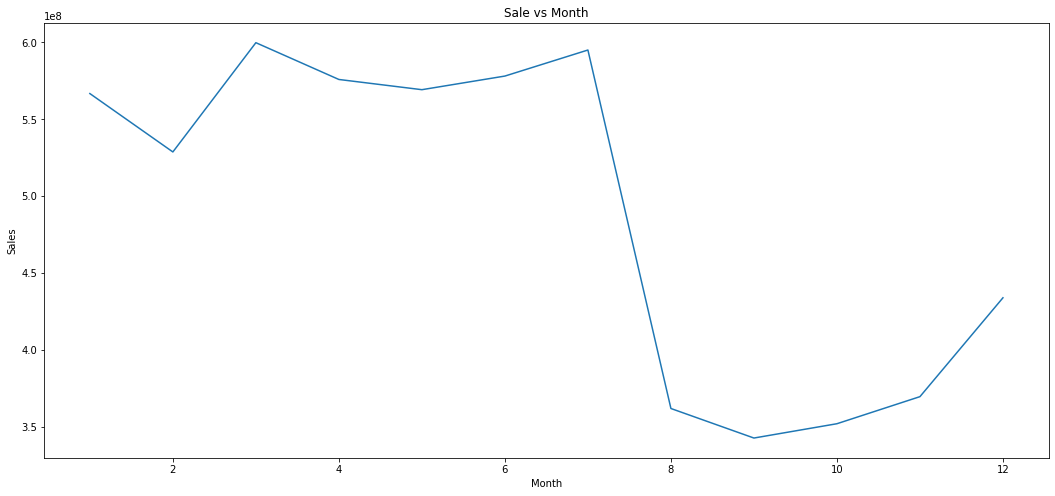

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby(df.Month).sum().Sales)
plt.title("Sale vs Month")
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

Sales are relatively are lower by the end of year. 

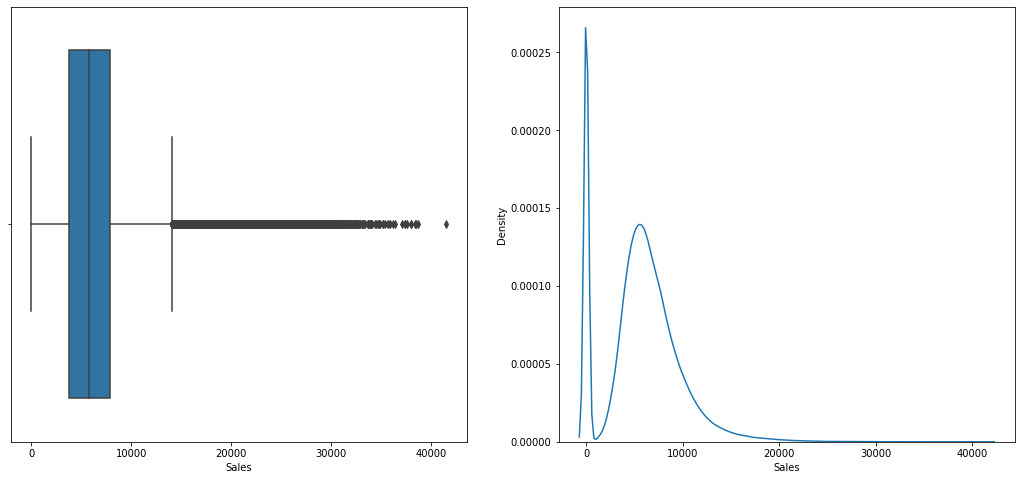

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
sns.boxplot(train.Sales, ax=ax1)
sns.kdeplot(train.Sales, ax=ax2)
plt.show()

Sales are 0 on a huge amount of days which could mean this is either imputed to fill gaps as it doesn't make sense for sale of a day to be 0. It could mean the store was closed, maybe there was a holiday. Lets see if this stands. 

In [ ]:
df[df.Open==0].Sales.value_counts()

0    172817
Name: Sales, dtype: int64

Seems like I was right! 172817 values are filled with 0. I will fill these values with np.NaN as some models like XGBoost can handle missing values and it might benifit from it. 

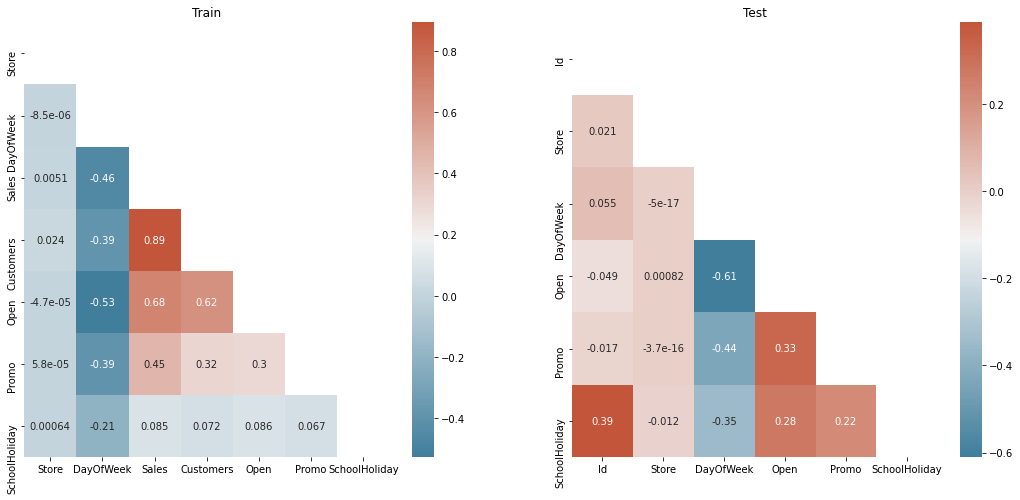

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(train.corr(), mask=mask, cmap=cmap, annot=True, ax=ax1)
ax1.set_title('Train')
corr = test.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(test.corr(), mask=mask, cmap=cmap, annot=True, ax=ax2)
ax2.set_title('Test')
plt.show()

Sales are highly correlated with feature Customers and feature Open and moderately correlated with Promo. Lets see some more plots about this!

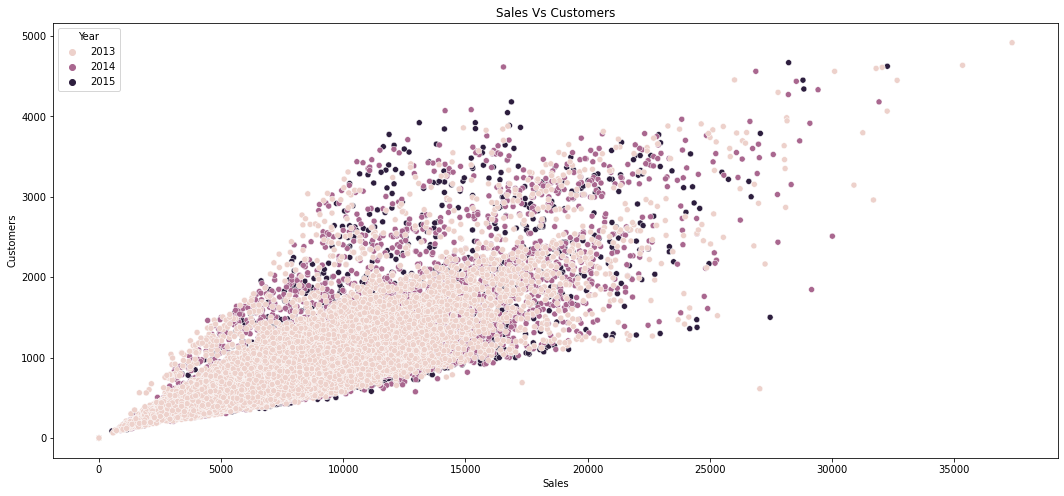

In [ ]:
plt.figure(figsize=(18,8))
temp_df = df.sample(100000)
sns.scatterplot(temp_df.Sales, temp_df.Customers, hue=df.Year)
plt.title("Sales Vs Customers")
plt.show()

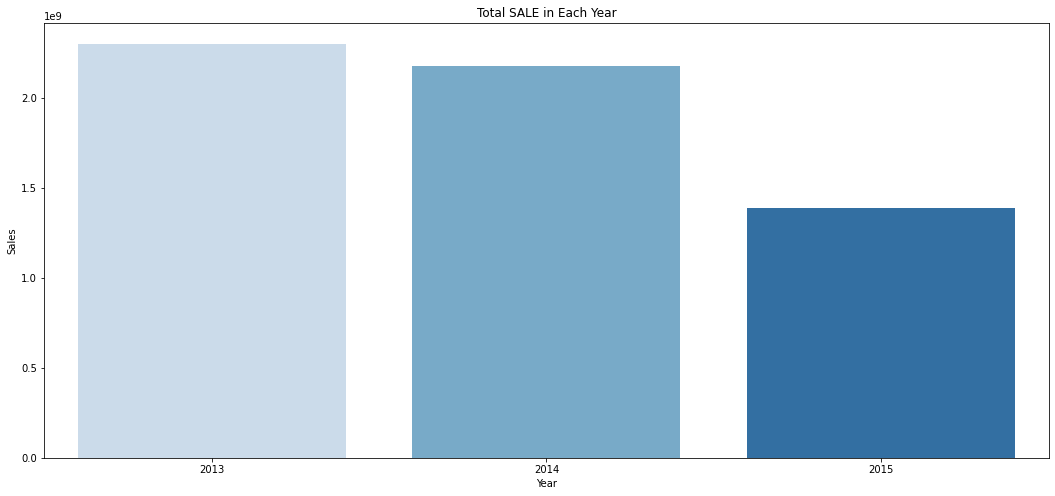

In [ ]:
plt.figure(figsize=(18,8))
temp_df = df.groupby(df.Year).sum()
sns.barplot(temp_df.index, temp_df.Sales, palette='Blues')
plt.title("Total SALE in Each Year")
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()

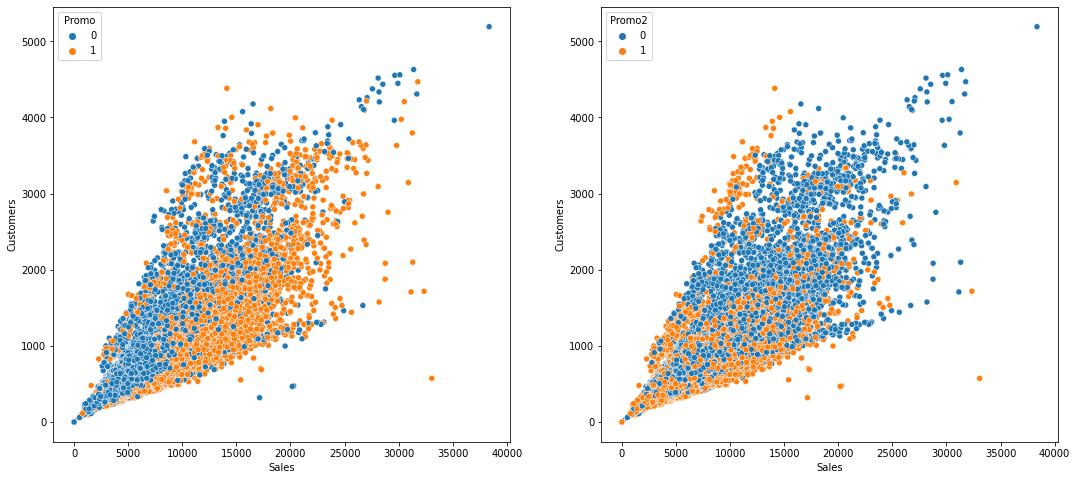

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
temp_df = df.sample(100000)
sns.scatterplot(temp_df.Sales, temp_df.Customers, hue=df.Promo, ax=ax1)
sns.scatterplot(temp_df.Sales, temp_df.Customers, hue=df.Promo2, ax=ax2)
plt.show()

Seems like Promo1 was more successful for the stores! Lets check the Sales for each promo on average. 

In [ ]:
df.groupby(df.Promo).Sales.mean()[1] > df.groupby(df.Promo2).Sales.mean()[1] #1 means store participated

True

Lets see if the type of store is a significant feature! Intuitively, stores inventory and ambience should be a huge factor. 

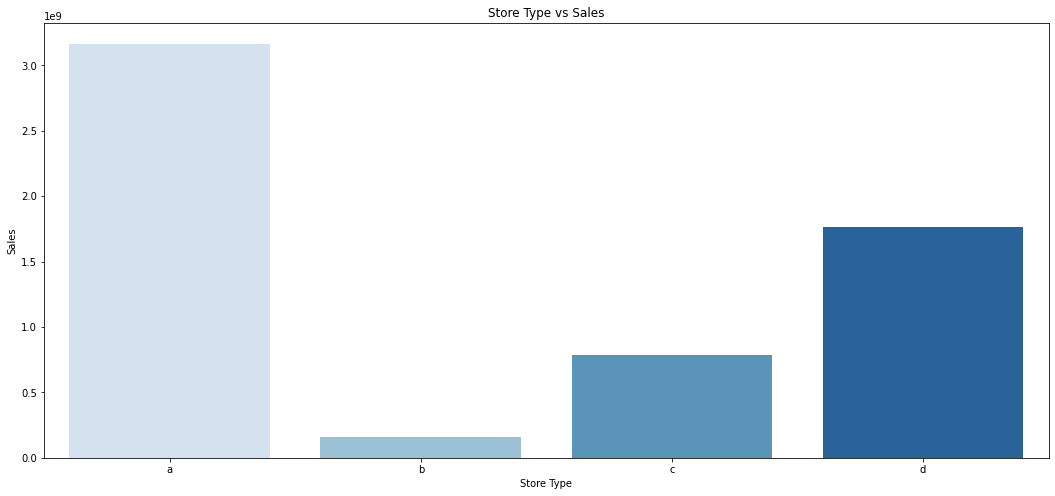

In [ ]:
plt.figure(figsize=(18,8))
temp_df = df.groupby(df.StoreType).sum()
sns.barplot(temp_df.index, temp_df.Sales, palette='Blues')
plt.title("Store Type vs Sales")
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

Why does Store A outperform all other stores?

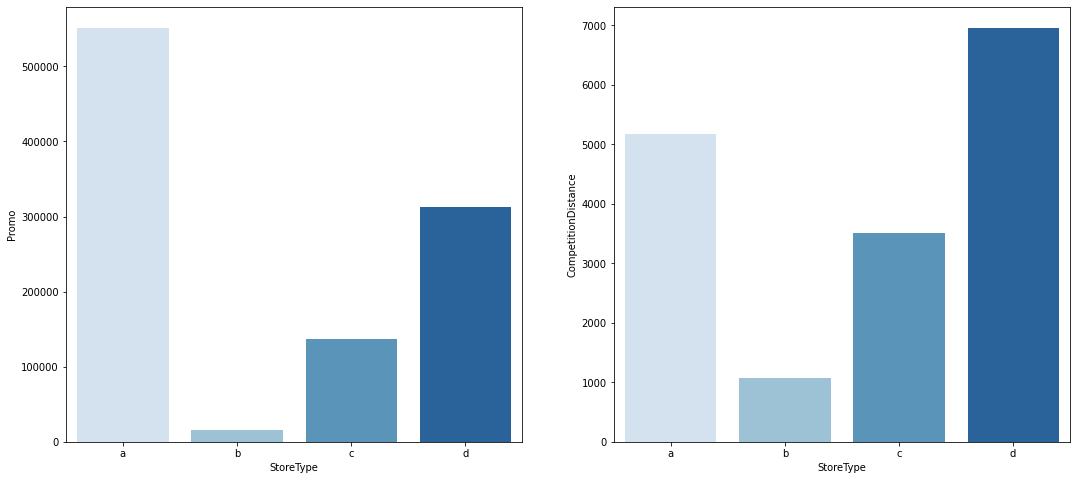

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
temp_df = df.groupby(df.StoreType).count()
sns.barplot(temp_df.index, temp_df['Promo'], ax=ax1, palette='Blues')
temp_df = df.groupby(df.StoreType).mean()
sns.barplot(temp_df.index, temp_df['CompetitionDistance'], ax=ax2, palette='Blues')
plt.show()

Store A did the most Promo'1's inspite of being on average top second in comparison to other stores with regard to Competition Distance (distance in meters to the nearest competitor store). Hence, I think it is fair to say promos are a big deal. Other factors could be seasonality, trend etc. Lets see about trend!

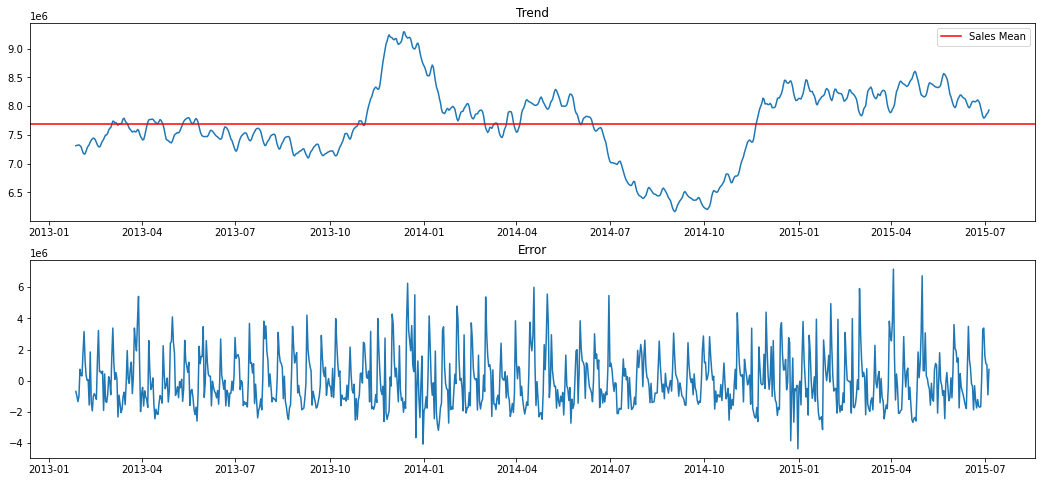

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
temp_df = train.copy()
temp_df.Date = pd.to_datetime(temp_df.Date)
temp_df.index = temp_df.Date
temp_df.Sales = temp_df.Sales.apply(lambda x: None if x == 0 else x)
temp_df.Sales = temp_df.Sales.fillna(method='ffill').fillna(method='bfill')
temp_df = temp_df[['Sales']]
temp_df = temp_df.groupby(temp_df.index).sum()
result = seasonal_decompose(temp_df, model='additive', freq=52)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,8))
ax1.plot(result.trend)
ax1.axhline(y = temp_df.Sales.mean(), color = 'r', linestyle = '-', label='Sales Mean')
ax1.set_title("Trend")
ax2.plot(result.resid)
ax2.set_title("Error")
ax1.legend()
plt.show()

2015 has been a good year as the trend line is above the average line by the end of 2014. Beginning of 2014 is a huge peak, I wonder what drived that?

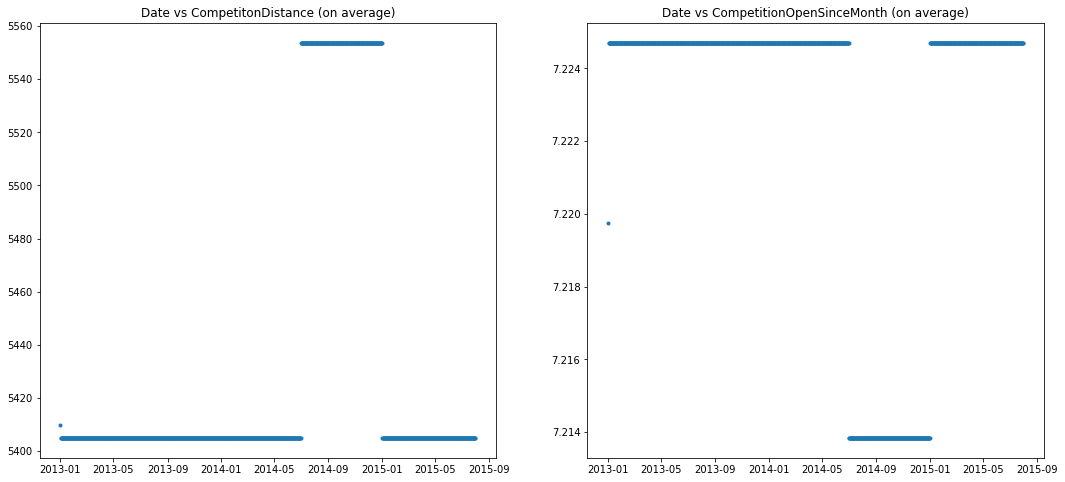

In [ ]:
temp_df = df.copy()
temp_df.index = temp_df.Date
temp_df.Sales = temp_df.Sales.apply(lambda x: None if x == 0 else x)
temp_df.Sales = temp_df.Sales.fillna(method='ffill').fillna(method='bfill')
temp_df = temp_df.groupby(temp_df.index).mean()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax1.plot(temp_df.CompetitionDistance, '.')
ax1.set_title("Date vs CompetitonDistance (on average)")
ax2.plot(temp_df.CompetitionOpenSinceMonth, '.')
ax2.set_title("Date vs CompetitionOpenSinceMonth (on average)")
plt.show()

Seems like there was a new competitor near the end of 2014 and since the distance also relatively increased it could be maybe change of location but these are just assumptions. It could be useful for the model to interpret such behaviour in the future for the stores. 

I wonder if the stores had done less promos when the trend was going down. Lets see!

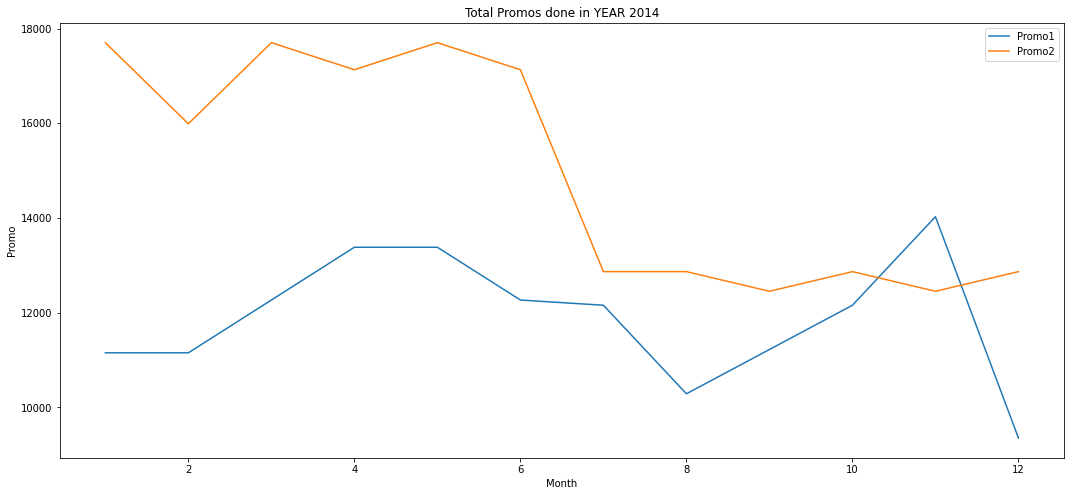

In [ ]:
plt.figure(figsize=(18,8))
temp_df = df.copy()
temp_df.index = temp_df.Date
temp_df = temp_df[temp_df.Year==2014]
temp_df = temp_df.groupby(temp_df.Month).sum()
temp_df.Sales = temp_df.Sales.apply(lambda x: None if x == 0 else x)
temp_df.Sales = temp_df.Sales.fillna(method='ffill').fillna(method='bfill')

plt.title('Total Promos done in YEAR 2014')
sns.lineplot(temp_df.index, temp_df.Promo, palette='Blues', label='Promo1')
sns.lineplot(temp_df.index, temp_df.Promo2, palette='Blues', label='Promo2')
plt.legend()
plt.show()

### Feature Engineering and Preprocessing

In [ ]:
features_x = ['Store', 'Date', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday']
features_y = ['SalesLog']

In [ ]:
train['is_train'] = 1
test['is_train'] = 0
df = pd.concat([train, test])

In [ ]:
df.Date = pd.to_datetime(df.Date) #Converting date to required format

In [ ]:
df = df.loc[~((df['Open'] == 1) & (df['Sales'] == 0))] #Removing rows with Sales 0

In [ ]:
df.StateHoliday = df.StateHoliday.map({0:'0', 'a':'a', 'b':'b', 'c':'c', '0':'0'}) #mixed data types
df.StateHoliday = LabelEncoder().fit_transform(df.StateHoliday) #Encoding for XG Boost

In [ ]:
var_name = 'Date'

df[var_name + 'Day'] = df[var_name].dt.day #addding day
df[var_name + 'Week'] = df[var_name].dt.week #adding week
df[var_name + 'Month'] = df[var_name].dt.month #adding month
df[var_name + 'Year'] = df[var_name].dt.year #adding year
df[var_name + 'DayOfYear'] = df[var_name].dt.dayofyear #adding dayofyear

features_x.remove(var_name) #removing Date
features_x.append(var_name + 'Day')
features_x.append(var_name + 'Week')
features_x.append(var_name + 'Month')
features_x.append(var_name + 'Year')
features_x.append(var_name + 'DayOfYear')

In [ ]:
store.StoreType = LabelEncoder().fit_transform(store.StoreType) #encoding StoreType
store.Assortment = LabelEncoder().fit_transform(store.Assortment) #encoding Assortment

In [ ]:
join_with = store['PromoInterval'].str.split(',').apply(pd.Series)
join_with.columns = join_with.columns.map(lambda x: str(x) + '_PromoInterval')
store = store.join(join_with) #joining splits

In [ ]:
def monthToNum(value):
    if(value=='Sept'):
        value='Sep'
    return list(calendar.month_abbr).index(value)
#mapping month abbr to month number
store['0_PromoInterval'] = store['0_PromoInterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store['1_PromoInterval'] = store['1_PromoInterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store['2_PromoInterval'] = store['2_PromoInterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store['3_PromoInterval'] = store['3_PromoInterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)

In [ ]:
competition_open = []
for index, value in store[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].iterrows():
    try:
        year, month = int(value['CompetitionOpenSinceYear']), int(value['CompetitionOpenSinceMonth'])
        date = pd.to_datetime("{}-{}-01".format(year, month), format='%Y-%m')
        competition_open.append(date)
    except:
        competition_open.append(np.nan)
competition_open = pd.Series(competition_open)
competition_open.shape

(1115,)

In [ ]:
store['CompetitionOpen'] = competition_open #converted int to datetime
store['CompetitionOpen'] = store.CompetitionOpen.dt.strftime('%Y%m%d')

In [ ]:
promo = []
for index, value in store[['Promo2SinceWeek', 'Promo2SinceYear']].iterrows():
    try:
        year, week = int(value['Promo2SinceYear']), int(value['Promo2SinceWeek'])
        date = pd.to_datetime("{}-{}-01".format(year, week), format='%Y%W')
        promo.append(date)
    except:
        promo.append(np.nan)
promo = pd.to_datetime(pd.Series(competition_open))
promo.shape

(1115,)

In [ ]:
store['PromoSince'] = promo #converted int to datetime
store['PromoSince'] = store.PromoSince.dt.strftime('%Y%m%d')

In [ ]:
store_features = ['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
                  'PromoSince', '0_PromoInterval']
#1_PromoInterval, 2_PromoInterval, 3_PromoInterval irrelevent

In [ ]:
df = pd.merge(df, store[store_features], how='left', on=['Store'])

In [ ]:
features_x = list(set(features_x + store_features))

In [ ]:
for feature in features_x:
    df[feature] = df[feature].fillna(-999) #out of range value for model

In [ ]:
df['DateInt'] = df.Date.dt.strftime('%Y%m%d').map(int) #mapping to Int
df['CompetitionOpen'] = df.CompetitionOpen.map(int)
df['PromoSince'] = df.PromoSince.map(int)

In [ ]:
df['Zscore'] = (df.Sales - df.Sales.mean())/df.Sales.std()

In [ ]:
thresh=4.0
def check_outlier(value):
    if(value>=thresh):
        return True
    else:
        return False

df['Outlier'] = df.Zscore.apply(check_outlier)

In [ ]:
store_data_sales = df.groupby([df['Store']])['Sales'].sum()
store_data_customers = df.groupby([df['Store']])['Customers'].sum()
store_data_open = df.groupby([df['Store']])['Open'].count()

store_data_sales_per_day = store_data_sales / store_data_open
store_data_customers_per_day = store_data_customers / store_data_open
store_data_sales_per_customer_per_day = store_data_sales_per_day / store_data_customers_per_day

df_store = pd.merge(store, store_data_sales_per_day.reset_index(name='SalesPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_data_customers_per_day.reset_index(name='CustomersPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_data_sales_per_customer_per_day.reset_index(name='SalesPerCustomersPerDay'), how='left', on=['Store'])

In [ ]:
store_features = ['Store', 'SalesPerDay', 'CustomersPerDay', 'SalesPerCustomersPerDay']

features_x = list(set(features_x + store_features))
df = pd.merge(df, df_store[store_features], how='left', on=['Store'])

In [ ]:
holidays_each_day_of_week = df.groupby(df.DayOfWeek).sum().StateHoliday
df = pd.merge(df, holidays_each_day_of_week.reset_index(name='HolidaysPerDayOfWeek'), on=['DayOfWeek'])

In [ ]:
school_holidays_each_day_of_week = df.groupby(df.DayOfWeek).sum().SchoolHoliday
df = pd.merge(df, school_holidays_each_day_of_week.reset_index(name='SchoolHolidaysPerDayOfWeek'), on=['DayOfWeek'])

In [ ]:
promo_each_day_of_week = df.groupby(df.DayOfWeek).sum().Promo
df = pd.merge(df, promo_each_day_of_week.reset_index(name='PromoPerDayOfWeek'), on=['DayOfWeek'])

In [ ]:
holidays_next_week=[]
holidays_next_week_index=[]
for index, value in df.groupby(df.Date).sum().iterrows():
    start_range = index + datetime.timedelta(days=7)
    end_range = index + datetime.timedelta(days=15)
    school_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).SchoolHoliday)
    state_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).StateHoliday)
    holidays_next_week.append(school_holidays+state_holidays)
    holidays_next_week_index.append(index)
    
holidays_next_week = pd.Series(holidays_next_week)
holidays_next_week.shape

(990,)

In [ ]:
holidays_this_week=[]
index_list = []
for index, value in df.groupby(df.Date).sum().iterrows():
    start_range = index 
    end_range = index + datetime.timedelta(days=7)
    school_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).SchoolHoliday)
    state_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).StateHoliday)
    holidays_this_week.append(school_holidays+state_holidays)
    index_list.append(index)
    
holidays_this_week = pd.Series(holidays_this_week)
holidays_this_week.shape

(990,)

In [ ]:
holidays_last_week=[]
holidays_last_week_index=[]
for index, value in df.groupby(df.Date).sum().iterrows():
    start_range = index - datetime.timedelta(days=7)
    end_range = index + datetime.timedelta(days=1)
    school_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).SchoolHoliday)
    state_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).StateHoliday)
    holidays_last_week.append(school_holidays+state_holidays)
    holidays_last_week_index.append(index)
    
holidays_last_week = pd.Series(holidays_next_week)
holidays_last_week.shape

(990,)

In [ ]:
temp_df = pd.DataFrame({'HolidaysNextWeek':holidays_next_week, 'Date': holidays_next_week_index})
df = pd.merge(df, temp_df, on=['Date'])

In [ ]:
temp_df = pd.DataFrame({'HolidaysThisWeek':holidays_this_week, 'Date': index_list})
df = pd.merge(df, temp_df, on=['Date'])

In [ ]:
temp_df = pd.DataFrame({'HolidaysLastWeek':holidays_last_week, 'Date': holidays_last_week_index})
df = pd.merge(df, temp_df, on=['Date'])

In [ ]:
holidays_features = ['HolidaysPerDayOfWeek', 'SchoolHolidaysPerDayOfWeek', 'PromoPerDayOfWeek', 
                     'HolidaysNextWeek', 'HolidaysThisWeek', 'HolidaysLastWeek']

features_x = list(set(features_x + holidays_features))

In [ ]:
#Most Promos are done on DayofWeek 4
df['DaysTillMaxPromo'] = df.DayOfWeek.apply(lambda x: 4-x)

In [ ]:
df['PromoTomorrow'] = df.Promo.shift(-1)
df['PromoYesterday'] = df.Promo.shift(1)

In [ ]:
promo_features = ['DaysTillMaxPromo', 'PromoTomorrow', 'PromoYesterday']

features_x = list(set(features_x + promo_features))

In [ ]:
df.Sales = df.Sales.apply(lambda x: np.nan if x == 0 else x) #Convert 0 to NaNs

In [ ]:
df.loc[df['is_train'] == 1, 'SalesLog'] = np.log(1+df.loc[df['is_train'] == 1]['Sales']) #Transforming Sales to 1+log

In [ ]:
len(features_x)

29

In [ ]:
df.shape

(1058243, 38)

In [ ]:
df.isnull().sum().sum()

1527143

# Modelling

In [ ]:
import xgboost as xgb

In [ ]:
data = df.loc[(df['is_train'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)]
x_train, x_test, y_train, y_test = train_test_split(data[features_x], 
                                                    data[features_y], 
                                                    test_size=0.1, 
                                                    random_state=42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

num_round = 20000
evallist = [(dtrain, 'train'), (dtest, 'test')]

param = {'max_depth': 9,
         'eta': 0.01,
         'subsample': 0.75,
         'colsample_bytree': 0.6, 
         'objective': 'reg:squarederror',}

plst = list(param.items())

model = xgb.train(plst, dtrain, num_round, evallist, 
                  feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=250)

(757442, 29) (757442, 1) (84161, 29) (84161, 1)
[0]	train-rmse:8.18188	train-rmspe:0.99986	test-rmse:8.17801	test-rmspe:0.99986
[250]	train-rmse:0.68244	train-rmspe:0.49269	test-rmse:0.68184	test-rmspe:0.48639
[500]	train-rmse:0.14281	train-rmspe:0.19554	test-rmse:0.14372	test-rmspe:0.14664
[750]	train-rmse:0.12101	train-rmspe:0.17995	test-rmse:0.12287	test-rmspe:0.13496
[1000]	train-rmse:0.11448	train-rmspe:0.16727	test-rmse:0.11698	test-rmspe:0.12896
[1250]	train-rmse:0.10984	train-rmspe:0.15950	test-rmse:0.11291	test-rmspe:0.12443
[1500]	train-rmse:0.10609	train-rmspe:0.15325	test-rmse:0.10968	test-rmspe:0.12087
[1750]	train-rmse:0.10304	train-rmspe:0.14717	test-rmse:0.10714	test-rmspe:0.11810
[2000]	train-rmse:0.10043	train-rmspe:0.14282	test-rmse:0.10502	test-rmspe:0.11586
[2250]	train-rmse:0.09839	train-rmspe:0.13918	test-rmse:0.10345	test-rmspe:0.11418
[2500]	train-rmse:0.09641	train-rmspe:0.13538	test-rmse:0.10193	test-rmspe:0.11256
[2750]	train-rmse:0.09456	train-rmspe:0.13150

<Figure size 1296x576 with 0 Axes>

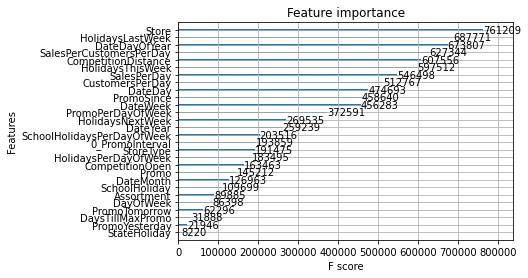

In [ ]:
#Print Feature Importance
plt.figure(figsize=(18,8))
from xgboost import plot_importance
plot_importance(model)
plt.show()

In [ ]:
submit = df.loc[df['is_train'] == 0]
dsubmit = xgb.DMatrix(submit[features_x])
predictions = model.predict(dsubmit)

df_predictions = submit['Id'].reset_index()
df_predictions['Id'] = df_predictions['Id'].astype('int')
df_predictions['Sales'] = (np.exp(predictions) - 1) * 0.985 #Scale Back

df_predictions.sort_values('Id', inplace=True)
df_predictions[['Id', 'Sales']].to_csv('solution.csv', index=False)